##T-Test

T-Test Analysis for AI vs Human Graph Metrics
Please update the file paths in the code before running:
AI_FILE = 'AI_english_pmi_graph_analysis_adv_spacy_lemma.xlsx'
HUMAN_FILE = 'Human_english_pmi_graph_analysis_adv_spacy_lemma.xlsx'

Then run:
results_df, assumptions_df = comprehensive_ttest_analysis(AI_FILE, HUMAN_FILE)
create_visualization(results_df)
Loaded AI data: 300 samples
Loaded Human data: 306 samples

Analyzing 26 graph metrics...
Processing: number_of_nodes
Processing: number_of_edges
Processing: density
Processing: connected
Processing: bipartite
Processing: planar
Processing: number_connected_components
Processing: size_largest_component
Processing: diameter
Processing: radius
Processing: avg_shortest_path_length
Processing: wiener_index
Processing: girth
Processing: avg_degree_centrality
Processing: avg_betweenness_centrality
Processing: avg_closeness_centrality
Processing: transitivity
Processing: avg_clustering
Processing: degeneracy
Processing: clique_number
Process

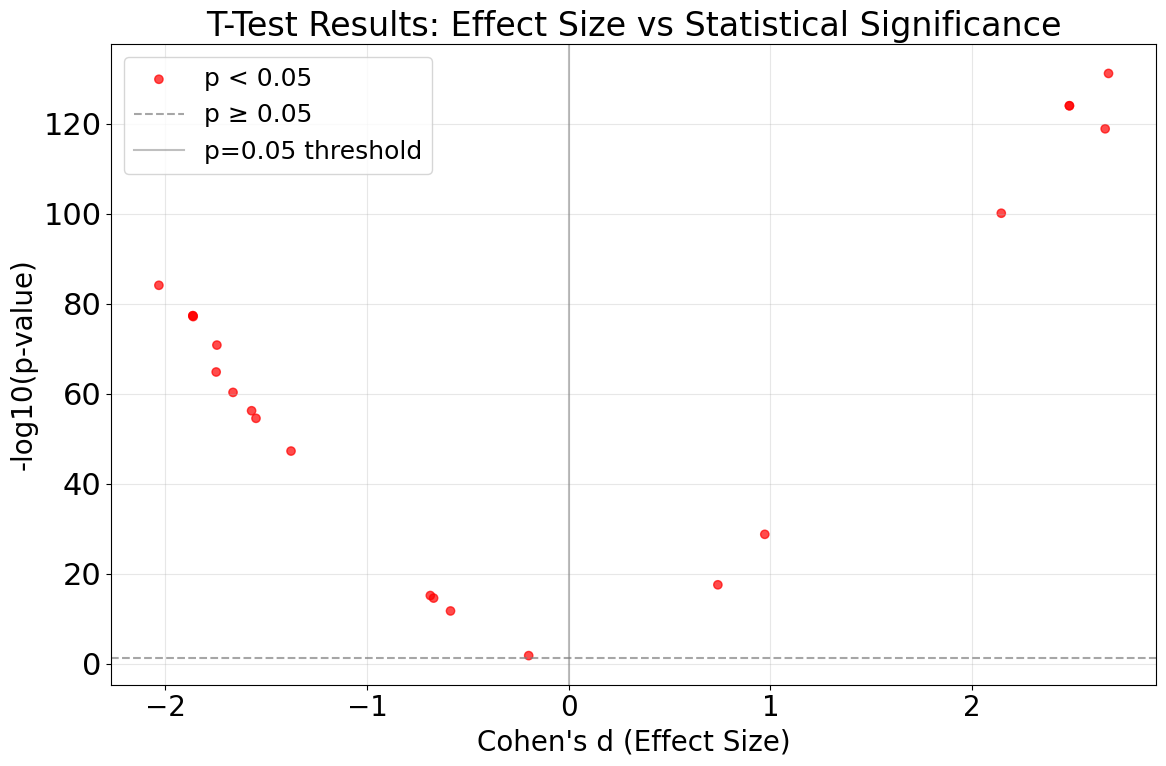

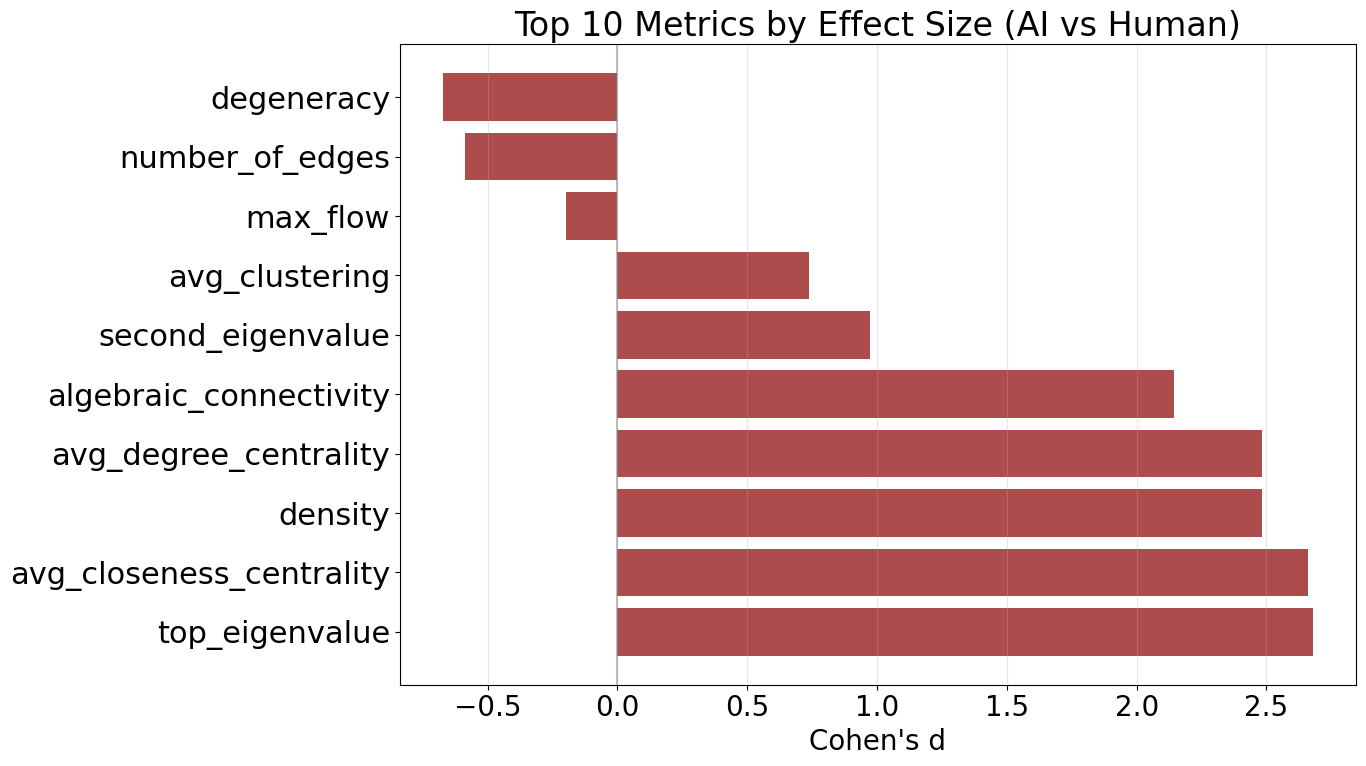

In [18]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, levene
import warnings
warnings.filterwarnings('ignore')

def load_and_prepare_data(ai_file, human_file):
    """
    Load AI and human graph metrics from Excel files

    Parameters:
    ai_file (str): Path to AI-generated text graph metrics Excel file
    human_file (str): Path to human-written text graph metrics Excel file

    Returns:
    ai_data (DataFrame): AI graph metrics
    human_data (DataFrame): Human graph metrics
    """
    try:
        ai_data = pd.read_excel(ai_file)
        human_data = pd.read_excel(human_file)

        # Remove the "Average" row if it exists
        ai_data = ai_data[ai_data['Graph'] != 'Average'].reset_index(drop=True)
        human_data = human_data[human_data['Graph'] != 'Average'].reset_index(drop=True)

        print(f"Loaded AI data: {len(ai_data)} samples")
        print(f"Loaded Human data: {len(human_data)} samples")

        return ai_data, human_data

    except FileNotFoundError as e:
        print(f"Error: Could not find file - {e}")
        return None, None
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

def check_assumptions(ai_values, human_values, metric_name):
    """
    Check assumptions for t-test: normality and equal variances

    Parameters:
    ai_values (array): AI metric values
    human_values (array): Human metric values
    metric_name (str): Name of the metric being tested

    Returns:
    dict: Results of assumption tests
    """
    results = {
        'metric': metric_name,
        'ai_normal': False,
        'human_normal': False,
        'equal_variances': False,
        'ai_shapiro_p': np.nan,
        'human_shapiro_p': np.nan,
        'levene_p': np.nan
    }

    # Remove NaN and infinite values
    ai_clean = ai_values[np.isfinite(ai_values)]
    human_clean = human_values[np.isfinite(human_values)]

    if len(ai_clean) < 3 or len(human_clean) < 3:
        print(f"Warning: {metric_name} has insufficient data for assumption testing")
        return results

    # Test normality using Shapiro-Wilk test
    try:
        ai_shapiro_stat, ai_shapiro_p = shapiro(ai_clean)
        results['ai_shapiro_p'] = ai_shapiro_p
        results['ai_normal'] = ai_shapiro_p > 0.05

        human_shapiro_stat, human_shapiro_p = shapiro(human_clean)
        results['human_shapiro_p'] = human_shapiro_p
        results['human_normal'] = human_shapiro_p > 0.05
    except Exception as e:
        print(f"Warning: Could not test normality for {metric_name}: {e}")

    # Test equal variances using Levene's test
    try:
        levene_stat, levene_p = levene(ai_clean, human_clean)
        results['levene_p'] = levene_p
        results['equal_variances'] = levene_p > 0.05
    except Exception as e:
        print(f"Warning: Could not test equal variances for {metric_name}: {e}")

    return results

def perform_ttest(ai_values, human_values, metric_name, equal_var=None):
    """
    Perform appropriate t-test based on assumptions

    Parameters:
    ai_values (array): AI metric values
    human_values (array): Human metric values
    metric_name (str): Name of the metric
    equal_var (bool): Whether to assume equal variances (None for auto-detect)

    Returns:
    dict: T-test results
    """
    # Remove NaN and infinite values
    ai_clean = ai_values[np.isfinite(ai_values)]
    human_clean = human_values[np.isfinite(human_values)]

    if len(ai_clean) < 2 or len(human_clean) < 2:
        return {
            'metric': metric_name,
            'ai_mean': np.nan,
            'human_mean': np.nan,
            'ai_std': np.nan,
            'human_std': np.nan,
            'ai_n': len(ai_clean),
            'human_n': len(human_clean),
            't_statistic': np.nan,
            'p_value': np.nan,
            'cohens_d': np.nan,
            'test_type': 'insufficient_data',
            'significant': False
        }

    # Calculate descriptive statistics
    ai_mean = np.mean(ai_clean)
    human_mean = np.mean(human_clean)
    ai_std = np.std(ai_clean, ddof=1)
    human_std = np.std(human_clean, ddof=1)

    # Perform t-test
    try:
        if equal_var is None:
            # Auto-detect using Levene's test
            _, levene_p = levene(ai_clean, human_clean)
            equal_var = levene_p > 0.05

        t_stat, p_val = stats.ttest_ind(ai_clean, human_clean, equal_var=equal_var)

        # Calculate Cohen's d (effect size)
        if equal_var:
            pooled_std = np.sqrt(((len(ai_clean) - 1) * ai_std**2 + (len(human_clean) - 1) * human_std**2) /
                               (len(ai_clean) + len(human_clean) - 2))
            cohens_d = (ai_mean - human_mean) / pooled_std
            test_type = "Student's t-test (equal variances)"
        else:
            cohens_d = (ai_mean - human_mean) / np.sqrt((ai_std**2 + human_std**2) / 2)
            test_type = "Welch's t-test (unequal variances)"

        return {
            'metric': metric_name,
            'ai_mean': ai_mean,
            'human_mean': human_mean,
            'ai_std': ai_std,
            'human_std': human_std,
            'ai_n': len(ai_clean),
            'human_n': len(human_clean),
            't_statistic': t_stat,
            'p_value': p_val,
            'cohens_d': cohens_d,
            'test_type': test_type,
            'significant': p_val < 0.05
        }

    except Exception as e:
        print(f"Error in t-test for {metric_name}: {e}")
        return {
            'metric': metric_name,
            'ai_mean': ai_mean,
            'human_mean': human_mean,
            'ai_std': ai_std,
            'human_std': human_std,
            'ai_n': len(ai_clean),
            'human_n': len(human_clean),
            't_statistic': np.nan,
            'p_value': np.nan,
            'cohens_d': np.nan,
            'test_type': 'error',
            'significant': False
        }

def multiple_comparison_correction(p_values, method='bonferroni'):
    """
    Apply multiple comparison correction

    Parameters:
    p_values (list): List of p-values
    method (str): Correction method ('bonferroni' or 'fdr_bh')

    Returns:
    corrected_p (list): Corrected p-values
    """
    from statsmodels.stats.multitest import multipletests

    # Remove NaN values for correction
    valid_indices = ~np.isnan(p_values)
    valid_p_values = np.array(p_values)[valid_indices]

    if len(valid_p_values) == 0:
        return p_values

    # Apply correction
    rejected, corrected_p_valid, _, _ = multipletests(valid_p_values, method=method)

    # Put corrected values back in original positions
    corrected_p = np.full_like(p_values, np.nan)
    corrected_p[valid_indices] = corrected_p_valid

    return corrected_p.tolist()

def comprehensive_ttest_analysis(ai_file, human_file, output_file='ttest_results.xlsx'):
    """
    Perform comprehensive t-test analysis on all graph metrics

    Parameters:
    ai_file (str): Path to AI data Excel file
    human_file (str): Path to human data Excel file
    output_file (str): Output file for results
    """

    # Load data
    ai_data, human_data = load_and_prepare_data(ai_file, human_file)
    if ai_data is None or human_data is None:
        return

    # Get numeric columns (exclude 'Graph' column)
    numeric_cols = [col for col in ai_data.columns if col != 'Graph' and
                   ai_data[col].dtype in ['int64', 'float64', 'int32', 'float32']]

    print(f"\nAnalyzing {len(numeric_cols)} graph metrics...")

    # Store results
    assumption_results = []
    ttest_results = []

    # Perform analysis for each metric
    for metric in numeric_cols:
        print(f"Processing: {metric}")

        ai_values = ai_data[metric].values
        human_values = human_data[metric].values

        # Check assumptions
        assumptions = check_assumptions(ai_values, human_values, metric)
        assumption_results.append(assumptions)

        # Perform t-test
        ttest_result = perform_ttest(ai_values, human_values, metric)
        ttest_results.append(ttest_result)

    # Convert results to DataFrames
    assumptions_df = pd.DataFrame(assumption_results)
    results_df = pd.DataFrame(ttest_results)

    # Apply multiple comparison correction
    p_values = results_df['p_value'].tolist()
    bonferroni_corrected = multiple_comparison_correction(p_values, 'bonferroni')
    fdr_corrected = multiple_comparison_correction(p_values, 'fdr_bh')

    results_df['p_bonferroni'] = bonferroni_corrected
    results_df['p_fdr_bh'] = fdr_corrected
    results_df['significant_bonferroni'] = [p < 0.05 if not np.isnan(p) else False for p in bonferroni_corrected]
    results_df['significant_fdr'] = [p < 0.05 if not np.isnan(p) else False for p in fdr_corrected]

    # Interpret Cohen's d effect sizes
    def interpret_cohens_d(d):
        if np.isnan(d):
            return 'N/A'
        abs_d = abs(d)
        if abs_d < 0.2:
            return 'negligible'
        elif abs_d < 0.5:
            return 'small'
        elif abs_d < 0.8:
            return 'medium'
        else:
            return 'large'

    results_df['effect_size_interpretation'] = results_df['cohens_d'].apply(interpret_cohens_d)

    # Save results to Excel
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        results_df.to_excel(writer, sheet_name='T-Test Results', index=False)
        assumptions_df.to_excel(writer, sheet_name='Assumption Tests', index=False)

    # Print summary
    print(f"\n{'='*60}")
    print("T-TEST ANALYSIS SUMMARY")
    print(f"{'='*60}")

    significant_uncorrected = results_df['significant'].sum()
    significant_bonferroni = results_df['significant_bonferroni'].sum()
    significant_fdr = results_df['significant_fdr'].sum()

    print(f"Total metrics analyzed: {len(results_df)}")
    print(f"Significant differences (uncorrected): {significant_uncorrected}")
    print(f"Significant differences (Bonferroni): {significant_bonferroni}")
    print(f"Significant differences (FDR): {significant_fdr}")

    print(f"\n{'='*60}")
    print("TOP DISCRIMINATING METRICS (by effect size)")
    print(f"{'='*60}")

    # Sort by absolute Cohen's d
    top_metrics = results_df[results_df['cohens_d'].notna()].copy()
    top_metrics['abs_cohens_d'] = top_metrics['cohens_d'].abs()
    top_metrics = top_metrics.sort_values('abs_cohens_d', ascending=False).head(10)

    for _, row in top_metrics.iterrows():
        direction = "AI > Human" if row['cohens_d'] > 0 else "Human > AI"
        print(f"{row['metric']:<30} | Cohen's d: {row['cohens_d']:.3f} ({row['effect_size_interpretation']}) | {direction}")

    print(f"\nResults saved to: {output_file}")

    return results_df, assumptions_df

def create_visualization(results_df, output_dir='plots'):
    """
    Create visualizations for t-test results
    """
    import os
    os.makedirs(output_dir, exist_ok=True)

    # Filter out invalid results
    valid_results = results_df[results_df['cohens_d'].notna() & results_df['p_value'].notna()]

    if len(valid_results) == 0:
        print("No valid results for visualization")
        return

    # 1. Effect size plot
    plt.figure(figsize=(12, 8))
    colors = ['red' if p < 0.05 else 'blue' for p in valid_results['p_value']]
    plt.scatter(valid_results['cohens_d'], -np.log10(valid_results['p_value']),
                c=colors, alpha=0.7)
    plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--', alpha=0.7, label='p=0.05')
    plt.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
    plt.xlabel("Cohen's d (Effect Size)")
    plt.ylabel("-log10(p-value)")
    plt.title("T-Test Results: Effect Size vs Statistical Significance")
    plt.legend(['p < 0.05', 'p ≥ 0.05', 'p=0.05 threshold'])
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/effect_size_volcano.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Top metrics bar plot
    plt.figure(figsize=(14, 8))
    top_10 = valid_results.nlargest(10, 'cohens_d', keep='all')
    colors = ['darkred' if p < 0.05 else 'darkblue' for p in top_10['p_value']]
    bars = plt.barh(range(len(top_10)), top_10['cohens_d'], color=colors, alpha=0.7)
    plt.yticks(range(len(top_10)), top_10['metric'])
    plt.xlabel("Cohen's d")
    plt.title("Top 10 Metrics by Effect Size (AI vs Human)")
    plt.axvline(x=0, color='gray', linestyle='-', alpha=0.5)
    plt.grid(True, axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/top_metrics_effect_size.png', dpi=300, bbox_inches='tight')
    plt.show()

# Example usage:
if __name__ == "__main__":
    # Replace these with your actual file paths
    AI_FILE = "AI_english_pmi_graph_analysis_adv_spacy_lemma.xlsx"
    HUMAN_FILE = "Human_english_pmi_graph_analysis_adv_spacy_lemma.xlsx"

    print("T-Test Analysis for AI vs Human Graph Metrics")
    print("=" * 50)
    print("Please update the file paths in the code before running:")
    print(f"AI_FILE = '{AI_FILE}'")
    print(f"HUMAN_FILE = '{HUMAN_FILE}'")
    print("\nThen run:")
    print("results_df, assumptions_df = comprehensive_ttest_analysis(AI_FILE, HUMAN_FILE)")
    print("create_visualization(results_df)")
    results_df, assumptions_df = comprehensive_ttest_analysis(AI_FILE, HUMAN_FILE)
    create_visualization(results_df)

##Consistency Test

In [19]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import shapiro, levene, pearsonr, spearmanr
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# ===============================
# SIMILARITY METRICS
# ===============================
def calculate_similarity_metrics(group1_data, group2_data, metric_name):
    g1_clean = group1_data[np.isfinite(group1_data)]
    g2_clean = group2_data[np.isfinite(group2_data)]

    if len(g1_clean) < 2 or len(g2_clean) < 2:
        return {k: np.nan for k in [
            'pearson_r','pearson_p','spearman_r','spearman_p','rmse','mae',
            'mean_diff','std_ratio','cv_similarity','overlap_coefficient','similarity_score'
        ]} | {'metric': metric_name}

    mean1, mean2 = np.mean(g1_clean), np.mean(g2_clean)
    std1, std2 = np.std(g1_clean, ddof=1), np.std(g2_clean, ddof=1)

    pooled_std = np.sqrt((std1**2 + std2**2) / 2)
    mean_diff = abs(mean1 - mean2) / (pooled_std if pooled_std > 0 else 1)

    std_ratio = min(std1, std2) / max(std1, std2) if max(std1, std2) > 0 else 1

    cv1 = std1 / abs(mean1) if abs(mean1) > 0 else np.inf
    cv2 = std2 / abs(mean2) if abs(mean2) > 0 else np.inf
    cv_similarity = 1 - abs(cv1 - cv2) / max(cv1, cv2) if max(cv1, cv2) > 0 else 0

    min_len = min(len(g1_clean), len(g2_clean))
    if min_len > 2:
        g1_sample = np.random.choice(g1_clean, min_len, replace=False)
        g2_sample = np.random.choice(g2_clean, min_len, replace=False)

        try:
            pearson_r, pearson_p = pearsonr(g1_sample, g2_sample)
        except:
            pearson_r, pearson_p = np.nan, np.nan
        try:
            spearman_r, spearman_p = spearmanr(g1_sample, g2_sample)
        except:
            spearman_r, spearman_p = np.nan, np.nan

        rmse = np.sqrt(mean_squared_error(g1_sample, g2_sample))
        mae = np.mean(np.abs(g1_sample - g2_sample))
    else:
        pearson_r = pearson_p = spearman_r = spearman_p = np.nan
        rmse = mae = np.nan

    try:
        all_values = np.concatenate([g1_clean, g2_clean])
        bins = np.histogram_bin_edges(all_values, bins='auto')
        hist1, _ = np.histogram(g1_clean, bins=bins, density=True)
        hist2, _ = np.histogram(g2_clean, bins=bins, density=True)
        overlap_coefficient = np.sum(np.minimum(hist1, hist2)) / np.sum(np.maximum(hist1, hist2))
    except:
        overlap_coefficient = np.nan

    similarity_components = []
    if not np.isnan(mean_diff):
        similarity_components.append(np.exp(-mean_diff))
    if not np.isnan(std_ratio):
        similarity_components.append(std_ratio)
    if not np.isnan(overlap_coefficient):
        similarity_components.append(overlap_coefficient)
    if not np.isnan(cv_similarity) and cv_similarity >= 0:
        similarity_components.append(cv_similarity)

    similarity_score = np.mean(similarity_components) if similarity_components else np.nan

    return {
        'metric': metric_name,
        'pearson_r': pearson_r,
        'pearson_p': pearson_p,
        'spearman_r': spearman_r,
        'spearman_p': spearman_p,
        'rmse': rmse,
        'mae': mae,
        'mean_diff': mean_diff,
        'std_ratio': std_ratio,
        'cv_similarity': cv_similarity,
        'overlap_coefficient': overlap_coefficient,
        'similarity_score': similarity_score
    }

# ===============================
# T-TEST + EFFECT SIZE
# ===============================
def perform_within_group_ttest(group1_values, group2_values, metric_name, group_name):
    g1_clean = group1_values[np.isfinite(group1_values)]
    g2_clean = group2_values[np.isfinite(group2_values)]

    if len(g1_clean) < 2 or len(g2_clean) < 2:
        return {'metric': metric_name, 'group': group_name,
                'group1_mean': np.nan,'group2_mean': np.nan,
                'group1_std': np.nan,'group2_std': np.nan,
                'group1_n': len(g1_clean),'group2_n': len(g2_clean),
                't_statistic': np.nan,'p_value': np.nan,
                'cohens_d': np.nan,'test_type': 'insufficient_data',
                'significant': False}

    g1_mean, g2_mean = np.mean(g1_clean), np.mean(g2_clean)
    g1_std, g2_std = np.std(g1_clean, ddof=1), np.std(g2_clean, ddof=1)

    try:
        _, levene_p = stats.levene(g1_clean, g2_clean)
        equal_var = levene_p > 0.05
    except:
        equal_var = True

    try:
        t_stat, p_val = stats.ttest_ind(g1_clean, g2_clean, equal_var=equal_var)
        if equal_var:
            pooled_std = np.sqrt(((len(g1_clean) - 1) * g1_std**2 +
                                  (len(g2_clean) - 1) * g2_std**2) /
                                 (len(g1_clean) + len(g2_clean) - 2))
            cohens_d = (g1_mean - g2_mean) / pooled_std
            test_type = "Student's t-test (equal variances)"
        else:
            cohens_d = (g1_mean - g2_mean) / np.sqrt((g1_std**2 + g2_std**2) / 2)
            test_type = "Welch's t-test (unequal variances)"

        return {'metric': metric_name,'group': group_name,
                'group1_mean': g1_mean,'group2_mean': g2_mean,
                'group1_std': g1_std,'group2_std': g2_std,
                'group1_n': len(g1_clean),'group2_n': len(g2_clean),
                't_statistic': t_stat,'p_value': p_val,
                'cohens_d': cohens_d,'test_type': test_type,
                'significant': p_val < 0.05}
    except Exception as e:
        return {'metric': metric_name,'group': group_name,
                'group1_mean': g1_mean,'group2_mean': g2_mean,
                'group1_std': g1_std,'group2_std': g2_std,
                'group1_n': len(g1_clean),'group2_n': len(g2_clean),
                't_statistic': np.nan,'p_value': np.nan,
                'cohens_d': np.nan,'test_type': f'error: {e}',
                'significant': False}

# ===============================
# MULTIPLE TEST CORRECTION
# ===============================
def multiple_comparison_correction(p_values, method='bonferroni'):
    from statsmodels.stats.multitest import multipletests
    p_values = np.array(p_values)
    valid_indices = ~np.isnan(p_values)
    if valid_indices.sum() == 0:
        return p_values.tolist()
    _, corrected_p, _, _ = multipletests(p_values[valid_indices], method=method)
    result = np.full_like(p_values, np.nan, dtype=float)
    result[valid_indices] = corrected_p
    return result.tolist()

# ===============================
# INTERPRETATION HELPERS
# ===============================
def interpret_cohens_d(d):
    if np.isnan(d): return 'N/A'
    abs_d = abs(d)
    if abs_d < 0.2: return 'negligible'
    elif abs_d < 0.5: return 'small'
    elif abs_d < 0.8: return 'medium'
    else: return 'large'

def interpret_similarity_score(score):
    if np.isnan(score): return 'N/A'
    if score >= 0.8: return 'very similar'
    elif score >= 0.6: return 'moderately similar'
    elif score >= 0.4: return 'somewhat similar'
    elif score >= 0.2: return 'dissimilar'
    else: return 'very dissimilar'

# ===============================
# SUMMARY PRINTER
# ===============================
def print_within_group_summary(ttest_df, similarity_df, group_name):
    print(f"\n{'-'*50}\n{group_name} CONSISTENCY SUMMARY\n{'-'*50}")
    total_metrics = len(ttest_df)
    print(f"Metrics with significant differences (uncorrected): {ttest_df['significant'].sum()}/{total_metrics}")
    print(f"Metrics with significant differences (FDR): {ttest_df['significant_fdr'].sum()}/{total_metrics}")
    print(f"Metrics with large effect sizes: {(ttest_df['cohens_d'].abs() > 0.8).sum()}")
    print(f"Metrics with medium effect sizes: {((ttest_df['cohens_d'].abs() > 0.5) & (ttest_df['cohens_d'].abs() <= 0.8)).sum()}")
    print(f"Metrics with high similarity (≥0.8): {(similarity_df['similarity_score'] >= 0.8).sum()}")
    print(f"Metrics with moderate similarity (0.6-0.8): {((similarity_df['similarity_score'] >= 0.6) & (similarity_df['similarity_score'] < 0.8)).sum()}")

# ===============================
# MAIN WITHIN-GROUP TEST
# ===============================
def within_group_consistency_test(df1, df2, group_name, output_file):
    numeric_cols = [c for c in df1.columns if c != 'Graph' and np.issubdtype(df1[c].dtype, np.number)]
    ttest_results, similarity_results = [], []
    for metric in numeric_cols:
        g1, g2 = df1[metric].values, df2[metric].values
        ttest_results.append(perform_within_group_ttest(g1, g2, metric, group_name))
        similarity_results.append(calculate_similarity_metrics(g1, g2, metric))
    ttest_df, similarity_df = pd.DataFrame(ttest_results), pd.DataFrame(similarity_results)

    p_vals = ttest_df['p_value'].tolist()
    ttest_df['p_bonferroni'] = multiple_comparison_correction(p_vals, 'bonferroni')
    ttest_df['p_fdr_bh'] = multiple_comparison_correction(p_vals, 'fdr_bh')
    ttest_df['significant_bonferroni'] = ttest_df['p_bonferroni'].apply(lambda p: p < 0.05 if not np.isnan(p) else False)
    ttest_df['significant_fdr'] = ttest_df['p_fdr_bh'].apply(lambda p: p < 0.05 if not np.isnan(p) else False)
    ttest_df['effect_size_interpretation'] = ttest_df['cohens_d'].apply(interpret_cohens_d)
    similarity_df['similarity_interpretation'] = similarity_df['similarity_score'].apply(interpret_similarity_score)

    combined_df = pd.merge(ttest_df, similarity_df, on='metric', how='inner')
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        combined_df.to_excel(writer, sheet_name=f'{group_name} Consistency', index=False)
        ttest_df.to_excel(writer, sheet_name='T-Test Results', index=False)
        similarity_df.to_excel(writer, sheet_name='Similarity Analysis', index=False)

    print_within_group_summary(ttest_df, similarity_df, group_name)
    return ttest_df, similarity_df, combined_df

# ===============================
# COMPREHENSIVE ANALYSIS WITH SPLIT
# ===============================
def comprehensive_within_group_analysis(human_file, ai_file):
    print("COMPREHENSIVE WITHIN-GROUP CONSISTENCY ANALYSIS\n" + "="*70)

    def prepare_splits(file_path):
        df = pd.read_excel(file_path)
        df = df[df['Graph'] != 'Average'].reset_index(drop=True)
        # df = df.sample(frac=1, random_state=42).reset_index(drop=True)  # shuffle
        df = df.sample(frac=1).reset_index(drop=True)
        half = len(df) // 2
        return df.iloc[:half].reset_index(drop=True), df.iloc[half:].reset_index(drop=True)

    human1, human2 = prepare_splits(human_file)
    ai1, ai2 = prepare_splits(ai_file)

    print("\nAnalyzing Human consistency...")
    human_ttest, human_sim, _ = within_group_consistency_test(human1, human2, "Human", "human_consistency_analysis.xlsx")

    print("\nAnalyzing AI consistency...")
    ai_ttest, ai_sim, _ = within_group_consistency_test(ai1, ai2, "AI", "ai_consistency_analysis.xlsx")

    print(f"\n{'='*70}\nCOMPARATIVE CONSISTENCY ANALYSIS\n{'='*70}")
    print(f"Human Average Similarity: {human_sim['similarity_score'].mean():.3f}")
    print(f"AI Average Similarity: {ai_sim['similarity_score'].mean():.3f}")

# ===============================
# Example usage
# ===============================
if __name__ == "__main__":
    HUMAN_FILE = "Human_english_pmi_graph_analysis_adv_spacy_lemma.xlsx"
    AI_FILE = "AI_english_pmi_graph_analysis_adv_spacy_lemma.xlsx"
    comprehensive_within_group_analysis(HUMAN_FILE, AI_FILE)


COMPREHENSIVE WITHIN-GROUP CONSISTENCY ANALYSIS

Analyzing Human consistency...

--------------------------------------------------
Human CONSISTENCY SUMMARY
--------------------------------------------------
Metrics with significant differences (uncorrected): 0/26
Metrics with significant differences (FDR): 0/26
Metrics with large effect sizes: 0
Metrics with medium effect sizes: 0
Metrics with high similarity (≥0.8): 18
Metrics with moderate similarity (0.6-0.8): 8

Analyzing AI consistency...

--------------------------------------------------
AI CONSISTENCY SUMMARY
--------------------------------------------------
Metrics with significant differences (uncorrected): 10/26
Metrics with significant differences (FDR): 8/26
Metrics with large effect sizes: 0
Metrics with medium effect sizes: 0
Metrics with high similarity (≥0.8): 16
Metrics with moderate similarity (0.6-0.8): 10

COMPARATIVE CONSISTENCY ANALYSIS
Human Average Similarity: 0.864
AI Average Similarity: 0.837


##Optimal Feature Extraction

OPTIMAL FEATURE IDENTIFICATION ANALYSIS
This analysis identifies the best graph metrics for AI vs Human classification
by combining:
1. High discrimination power (AI vs Human differences)
2. High reliability (within-group consistency)

Required files:
- AI vs Human t-test results
- Human vs Human consistency analysis
- AI vs AI consistency analysis

Update the file paths below and run:
optimal_features_df = identify_optimal_classification_features(...)
OPTIMAL CLASSIFICATION FEATURE IDENTIFICATION
Loaded AI vs Human results: 26 metrics
Loaded Human consistency similarity results: 26 metrics
Loaded AI consistency similarity results: 26 metrics
Loaded Human consistency T-Test results: 26 metrics
Loaded AI consistency T-Test results: 26 metrics

--- Merging Process ---
AI vs Human columns: ['metric', 'ai_mean', 'human_mean', 'ai_std', 'human_std', 'ai_n', 'human_n', 't_statistic', 'p_value', 'cohens_d', 'test_type', 'significant', 'p_bonferroni', 'p_fdr_bh', 'significant_bonferroni', 'sig

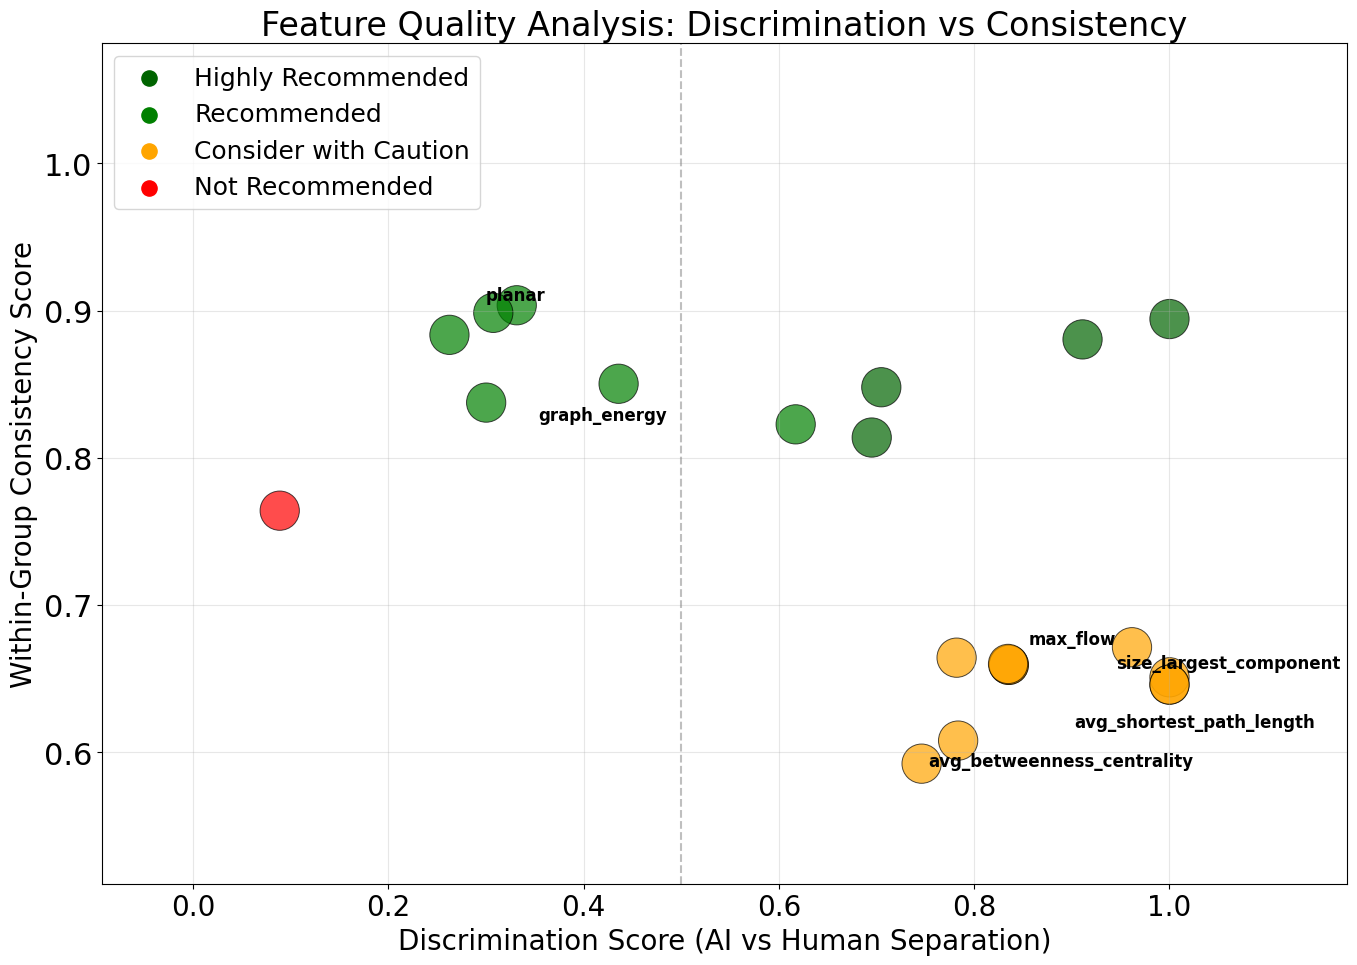

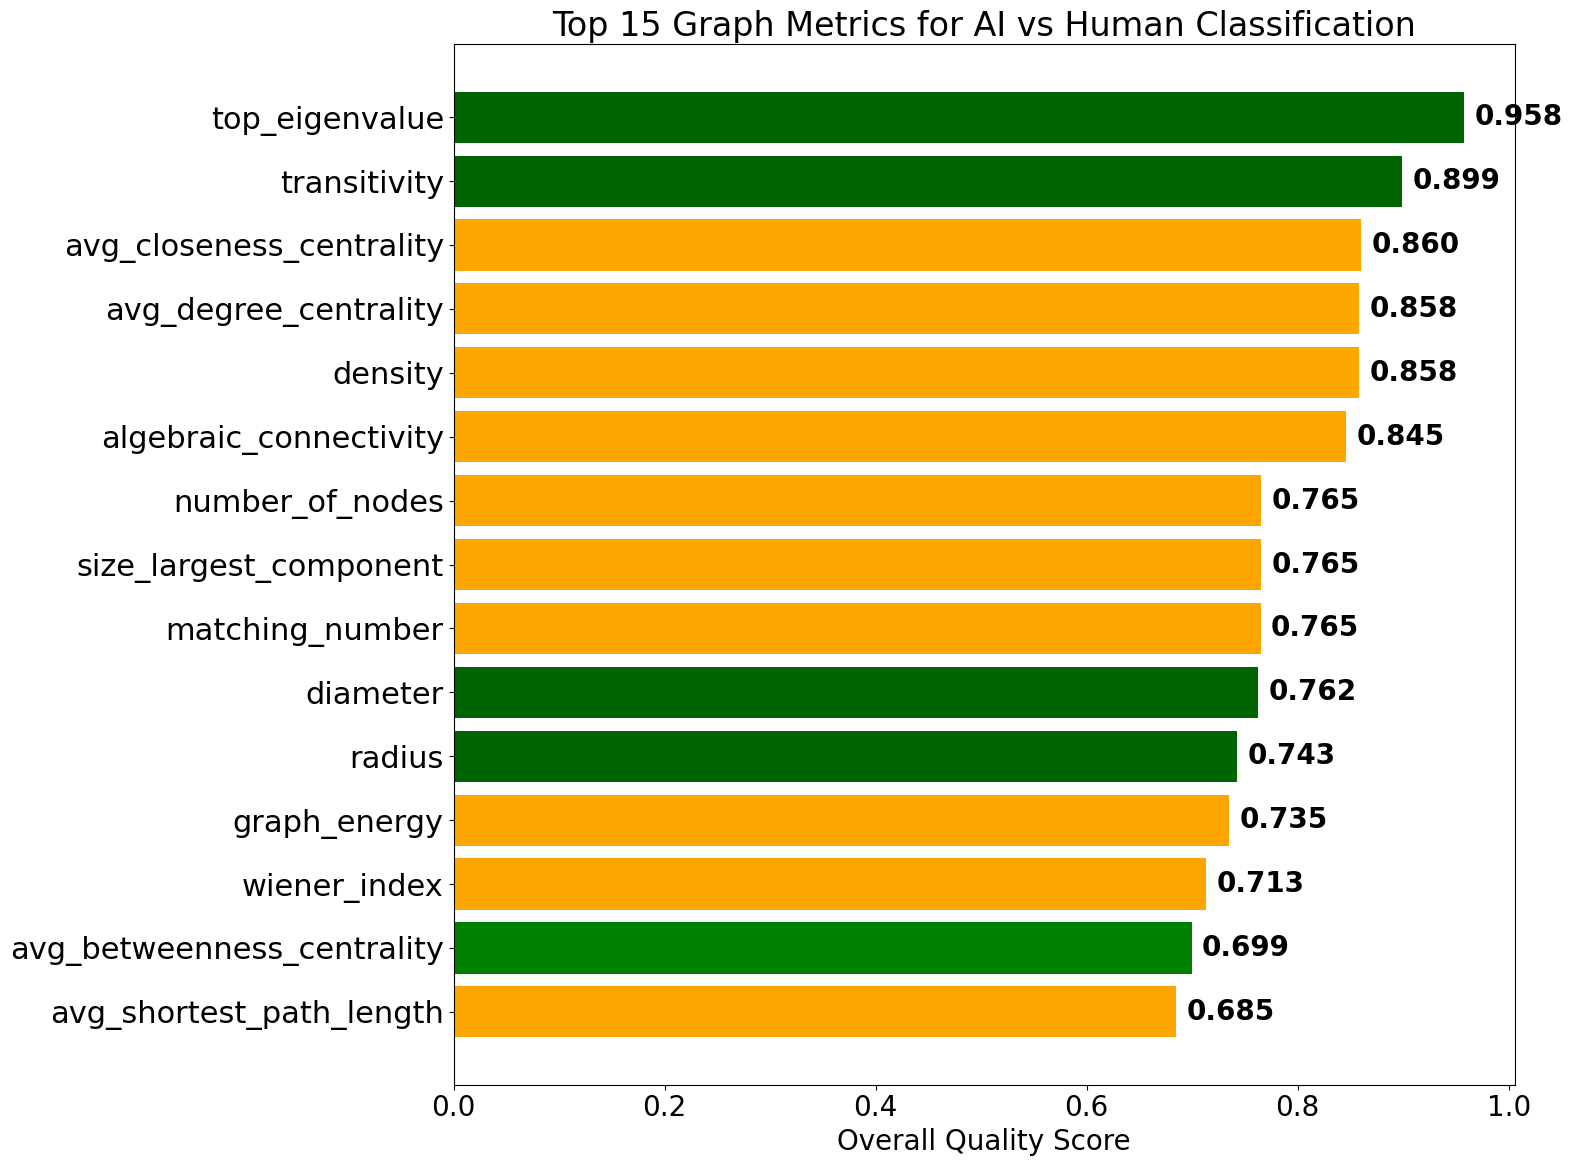

Recommendation counts:  feature_recommendation
Consider with Caution    10
Recommended               6
N/A                       5
Highly Recommended        4
Not Recommended           1
Name: count, dtype: int64


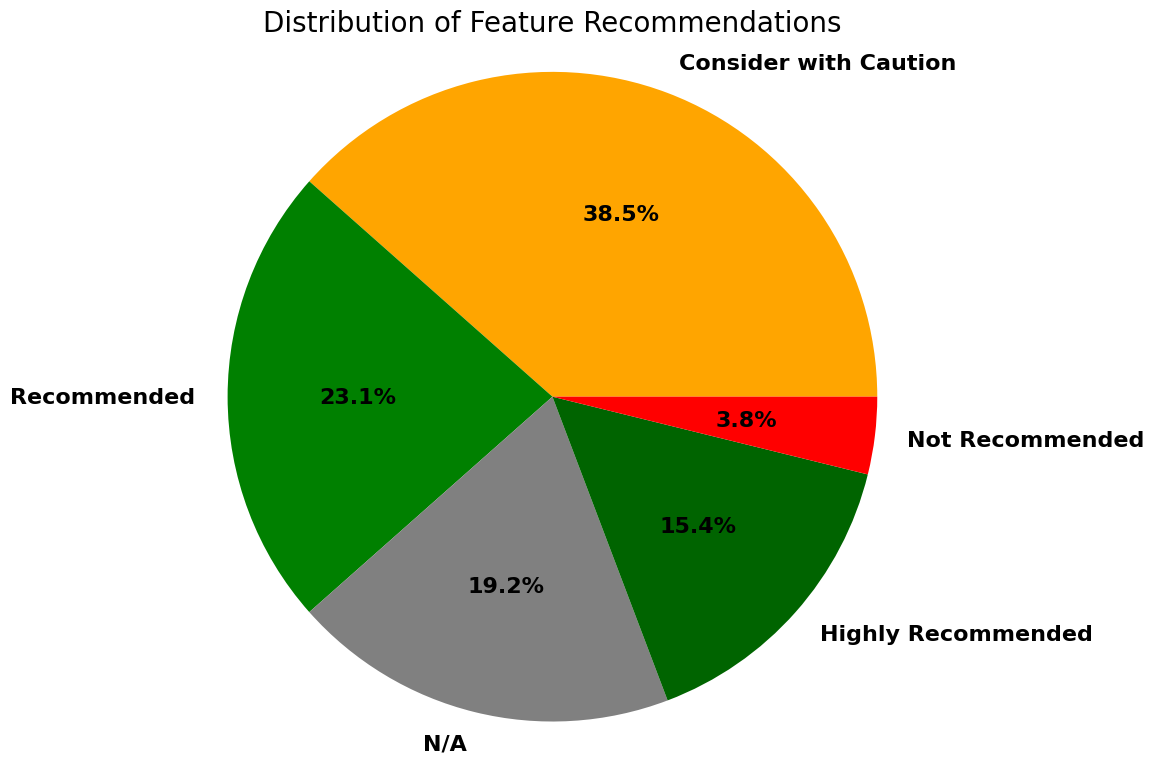

                      metric  overall_quality_score feature_recommendation
21            top_eigenvalue               0.957699     Highly Recommended
16              transitivity               0.898747     Highly Recommended
15  avg_closeness_centrality               0.860333  Consider with Caution
13     avg_degree_centrality               0.858350  Consider with Caution
2                    density               0.858350  Consider with Caution
25    algebraic_connectivity               0.845469  Consider with Caution
0            number_of_nodes               0.764997  Consider with Caution
7     size_largest_component               0.764997  Consider with Caution
24           matching_number               0.764785  Consider with Caution
8                   diameter               0.762112     Highly Recommended


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from functools import reduce
from adjustText import adjust_text

warnings.filterwarnings('ignore')

def identify_optimal_classification_features(ai_human_results_file, human_consistency_file, ai_consistency_file, output_file='optimal_features.xlsx'):
    """
    Identify graph metrics that show:
    1. Large differences between AI and Human (high discriminative power)
    2. High consistency within AI group and within Human group (reliability)

    Parameters:
    ai_human_results_file (str): T-test results from AI vs Human analysis
    human_consistency_file (str): Results from Human vs Human consistency analysis
    ai_consistency_file (str): Results from AI vs AI consistency analysis
    output_file (str): Output file path

    Returns:
    DataFrame: Ranked features with combined scores
    """

    print("OPTIMAL CLASSIFICATION FEATURE IDENTIFICATION")
    print("="*60)

    try:
        # Load AI vs Human results
        ai_human_df = pd.read_excel(ai_human_results_file)
        print(f"Loaded AI vs Human results: {len(ai_human_df)} metrics")

        # Load within-group consistency results - specifically the 'Similarity Analysis' sheet
        human_consistency_sim_df = pd.read_excel(human_consistency_file, sheet_name='Similarity Analysis')
        ai_consistency_sim_df = pd.read_excel(ai_consistency_file, sheet_name='Similarity Analysis')
        print(f"Loaded Human consistency similarity results: {len(human_consistency_sim_df)} metrics")
        print(f"Loaded AI consistency similarity results: {len(ai_consistency_sim_df)} metrics")

        # Load T-Test results from consistency files for p-values/effect sizes
        human_consistency_ttest_df = pd.read_excel(human_consistency_file, sheet_name='T-Test Results')
        ai_consistency_ttest_df = pd.read_excel(ai_consistency_file, sheet_name='T-Test Results')
        print(f"Loaded Human consistency T-Test results: {len(human_consistency_ttest_df)} metrics")
        print(f"Loaded AI consistency T-Test results: {len(ai_consistency_ttest_df)} metrics")


    except Exception as e:
        print(f"Error loading files: {e}")
        return None

    print("\n--- Merging Process ---")
    print("AI vs Human columns:", list(ai_human_df.columns))
    print("Human Consistency Similarity columns:", list(human_consistency_sim_df.columns))
    print("AI Consistency Similarity columns:", list(ai_consistency_sim_df.columns))
    print("Human Consistency T-Test columns:", list(human_consistency_ttest_df.columns))
    print("AI Consistency T-Test columns:", list(ai_consistency_ttest_df.columns))


    # Prepare dataframes for merging, renaming columns explicitly
    ai_human_subset = ai_human_df[['metric', 'cohens_d', 'p_fdr_bh', 'significant_fdr']].rename(columns={
        'cohens_d': 'between_group_effect_size',
        'p_fdr_bh': 'between_group_p_fdr',
        'significant_fdr': 'between_group_significant'
    })

    human_sim_subset = human_consistency_sim_df[['metric', 'similarity_score']].rename(columns={
        'similarity_score': 'human_within_similarity'
    })

    ai_sim_subset = ai_consistency_sim_df[['metric', 'similarity_score']].rename(columns={
        'similarity_score': 'ai_within_similarity'
    })

    human_ttest_subset = human_consistency_ttest_df[['metric', 'cohens_d', 'p_value']].rename(columns={
        'cohens_d': 'human_within_effect_size',
        'p_value': 'human_within_p_value'
    })

    ai_ttest_subset = ai_consistency_ttest_df[['metric', 'cohens_d', 'p_value']].rename(columns={
        'cohens_d': 'ai_within_effect_size',
        'p_value': 'ai_within_p_value'
    })


    # List of dataframes to merge
    data_frames = [ai_human_subset, human_sim_subset, ai_sim_subset, human_ttest_subset, ai_ttest_subset]

    # Merge dataframes sequentially using reduce
    try:
        merged_df = reduce(lambda left, right: pd.merge(left, right, on='metric', how='inner'), data_frames)
        print("\nColumns after merging all dataframes:", list(merged_df.columns))
        print(f"Successfully merged data for {len(merged_df)} metrics")

    except Exception as e:
        print(f"Error merging data: {e}")
        return None


    # Calculate feature quality scores
    merged_df = calculate_feature_quality_scores(merged_df)

    # Rank features by overall quality
    merged_df = merged_df.sort_values('overall_quality_score', ascending=False)

    # Add interpretations
    merged_df = add_feature_interpretations(merged_df)

    # Create summary statistics
    summary_stats = create_feature_summary(merged_df)

    # Save results
    with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
        merged_df.to_excel(writer, sheet_name='Ranked Features', index=False)
        summary_stats.to_excel(writer, sheet_name='Summary Statistics', index=False)

        # Create feature categories
        create_feature_categories(merged_df, writer)

    # Print results
    print_optimal_features_summary(merged_df, summary_stats)

    # Create visualizations
    create_feature_quality_plots(merged_df)

    return merged_df

def calculate_feature_quality_scores(df):
    """
    Calculate quality scores for each feature based on:
    1. Between-group discriminative power (AI vs Human)
    2. Within-group consistency (AI vs AI, Human vs Human)
    """

    # Component 1: Between-group discriminative power (0-1 scale)
    # Higher absolute Cohen's d = better discrimination
    # Handle potential NaN in effect size before calculating max
    max_effect_size = df['between_group_effect_size'].abs().max()
    if pd.isna(max_effect_size) or max_effect_size == 0:
         df['discrimination_score'] = 0
    else:
        df['discrimination_score'] = df['between_group_effect_size'].abs() / max_effect_size


    # Bonus for statistical significance
    # Ensure 'between_group_significant' is boolean or handle NaN
    df['between_group_significant'] = df['between_group_significant'].fillna(False)
    df.loc[df['between_group_significant'] == True, 'discrimination_score'] *= 1.2
    df['discrimination_score'] = np.clip(df['discrimination_score'], 0, 1)


    # Component 2: Within-group consistency score (0-1 scale)
    # Higher similarity = better consistency
    # Use the correct column names obtained from the merge and rename step
    df['human_consistency_score'] = df['human_within_similarity'].fillna(0)
    df['ai_consistency_score'] = df['ai_within_similarity'].fillna(0)

    # Penalty for significant within-group differences (indicates inconsistency)
    # Ensure p-value columns exist and handle NaN
    df['human_within_p_value'] = df['human_within_p_value'].fillna(1.0) # Treat NaN p-values as non-significant
    df['ai_within_p_value'] = df['ai_within_p_value'].fillna(1.0)

    df.loc[df['human_within_p_value'] < 0.05, 'human_consistency_score'] *= 0.5
    df.loc[df['ai_within_p_value'] < 0.05, 'ai_consistency_score'] *= 0.5


    # Combined within-group consistency
    df['within_group_consistency'] = (df['human_consistency_score'] + df['ai_consistency_score']) / 2

    # Component 3: Overall quality score
    # Weighted combination: 60% discrimination, 40% consistency
    df['overall_quality_score'] = (0.6 * df['discrimination_score'] +
                                  0.4 * df['within_group_consistency'])

    # Component 4: Reliability indicator
    # Both groups must have reasonable consistency (>0.5) and significant between-group difference
    df['high_reliability'] = ((df['human_consistency_score'] > 0.5) &
                             (df['ai_consistency_score'] > 0.5) &
                             (df['between_group_significant'] == True))


    return df

def add_feature_interpretations(df):
    """Add human-readable interpretations"""

    # Discrimination quality
    def discrimination_quality(score):
        if np.isnan(score): return 'N/A'
        if score >= 0.8:
            return 'Excellent'
        elif score >= 0.6:
            return 'Good'
        elif score >= 0.4:
            return 'Moderate'
        elif score >= 0.2:
            return 'Poor'
        else:
            return 'Very Poor'

    # Consistency quality
    def consistency_quality(score):
        if np.isnan(score): return 'N/A'
        if score >= 0.8:
            return 'Very Consistent'
        elif score >= 0.6:
            return 'Consistent'
        elif score >= 0.4:
            return 'Moderately Consistent'
        elif score >= 0.2:
            return 'Inconsistent'
        else:
            return 'Very Inconsistent'

    # Overall recommendation
    def feature_recommendation(overall_score, reliability):
        if np.isnan(overall_score): return 'N/A'
        if reliability and overall_score >= 0.7:
            return 'Highly Recommended'
        elif reliability and overall_score >= 0.5:
            return 'Recommended'
        elif overall_score >= 0.6:
            return 'Consider with Caution'
        else:
            return 'Not Recommended'

    df['discrimination_quality'] = df['discrimination_score'].apply(discrimination_quality)
    df['consistency_quality'] = df['within_group_consistency'].apply(consistency_quality)
    df['feature_recommendation'] = df.apply(lambda row: feature_recommendation(
        row['overall_quality_score'], row['high_reliability']), axis=1)

    return df

def create_feature_summary(df):
    """Create summary statistics"""

    summary_data = {
        'Category': [
            'Total Metrics Analyzed',
            'Highly Recommended Features',
            'Recommended Features',
            'Features with Excellent Discrimination',
            'Features with Good Consistency',
            'High Reliability Features',
            'Average Overall Quality Score',
            'Average Discrimination Score',
            'Average Consistency Score'
        ],
        'Count/Value': [
            len(df),
            len(df[df['feature_recommendation'] == 'Highly Recommended']),
            len(df[df['feature_recommendation'] == 'Recommended']),
            len(df[df['discrimination_quality'] == 'Excellent']),
            len(df[df['consistency_quality'].isin(['Very Consistent', 'Consistent'])]),
            len(df[df['high_reliability'] == True]),
            f"{df['overall_quality_score'].mean():.3f}",
            f"{df['discrimination_score'].mean():.3f}",
            f"{df['within_group_consistency'].mean():.3f}"
        ]
    }

    return pd.DataFrame(summary_data)

def create_feature_categories(df, writer):
    """Create categorized feature lists"""

    # Highly recommended features
    highly_recommended = df[df['feature_recommendation'] == 'Highly Recommended'][
        ['metric', 'overall_quality_score', 'discrimination_score', 'within_group_consistency',
         'between_group_effect_size', 'between_group_p_fdr']
    ].copy()

    # Good discrimination features
    excellent_discrimination = df[df['discrimination_quality'] == 'Excellent'][
        ['metric', 'discrimination_score', 'between_group_effect_size', 'between_group_p_fdr',
         'consistency_quality']
    ].copy()

    # High consistency features
    high_consistency = df[df['consistency_quality'].isin(['Very Consistent', 'Consistent'])][
        ['metric', 'within_group_consistency', 'human_within_similarity', 'ai_within_similarity',
         'discrimination_quality']
    ].copy()

    # Save categorized results
    if len(highly_recommended) > 0:
        highly_recommended.to_excel(writer, sheet_name='Highly Recommended', index=False)
    if len(excellent_discrimination) > 0:
        excellent_discrimination.to_excel(writer, sheet_name='Excellent Discrimination', index=False)
    if len(high_consistency) > 0:
        high_consistency.to_excel(writer, sheet_name='High Consistency', index=False)

def print_optimal_features_summary(df, summary_stats):
    """Print comprehensive summary of results"""

    print(f"\n{'='*60}")
    print("FEATURE QUALITY ANALYSIS SUMMARY")
    print(f"{'='*60}")

    # Overall statistics
    for _, row in summary_stats.iterrows():
        print(f"{row['Category']}: {row['Count/Value']}")

    print(f"\n{'='*60}")
    print("TOP 10 RECOMMENDED FEATURES")
    print(f"{'='*60}")

    top_features = df.head(10)
    for idx, (_, row) in enumerate(top_features.iterrows(), 1):
        print(f"{idx:2d}. {row['metric']:<30}")
        print(f"    Overall Score: {row['overall_quality_score']:.3f} ({row['feature_recommendation']})")
        print(f"    Discrimination: {row['discrimination_score']:.3f} ({row['discrimination_quality']})")
        print(f"    Consistency: {row['within_group_consistency']:.3f} ({row['consistency_quality']})")
        print(f"    Effect Size: {row['between_group_effect_size']:.3f}")
        print(f"    Reliable: {'Yes' if row['high_reliability'] else 'No'}")
        print()

    # Reliability analysis
    reliable_features = df[df['high_reliability'] == True]
    print(f"{'='*60}")
    print(f"HIGHLY RELIABLE FEATURES ({len(reliable_features)} total):")
    print(f"{'='*60}")

    if len(reliable_features) > 0:
        for _, row in reliable_features.head(5).iterrows():
            direction = "AI > Human" if row['between_group_effect_size'] > 0 else "Human > AI"
            print(f"• {row['metric']:<30} | {direction} | Score: {row['overall_quality_score']:.3f}")
    else:
        print("No features meet high reliability criteria.")
        print("Consider: 1) Collecting more data, 2) Different graph metrics, 3) Alternative methods")

    print(f"\n{'='*60}")
    print("RECOMMENDATIONS FOR CLASSIFICATION")
    print(f"{'='*60}")

    highly_recommended = len(df[df['feature_recommendation'] == 'Highly Recommended'])
    recommended = len(df[df['feature_recommendation'] == 'Recommended'])

    if highly_recommended >= 5:
        print("✓ Excellent: You have sufficient high-quality features for robust classification")
        print("  Recommend: Use top 5-10 features in your classifier")
    elif highly_recommended + recommended >= 5:
        print("✓ Good: You have adequate features for classification")
        print("  Recommend: Use all highly recommended + top recommended features")
    elif highly_recommended + recommended >= 3:
        print("⚠ Moderate: Limited but usable features available")
        print("  Recommend: Use all available good features + feature engineering")
    else:
        print("⚠ Poor: Insufficient reliable discriminating features")
        print("  Recommend: 1) Collect more data, 2) Try different graph construction methods")

# def create_feature_quality_plots(df, output_dir='feature_plots'):
#     """Create visualizations for feature quality analysis"""

#     import os
#     os.makedirs(output_dir, exist_ok=True)

#     # Set style
#     plt.style.use('default')
#     sns.set_palette("husl")

#     # 1. Discrimination vs Consistency Scatter Plot
#     plt.figure(figsize=(12, 8))

#     colors = []
#     for _, row in df.iterrows():
#         if row['feature_recommendation'] == 'Highly Recommended':
#             colors.append('darkgreen')
#         elif row['feature_recommendation'] == 'Recommended':
#             colors.append('green')
#         elif row['feature_recommendation'] == 'Consider with Caution':
#             colors.append('orange')
#         else:
#             colors.append('red')

#     scatter = plt.scatter(df['discrimination_score'], df['within_group_consistency'],
#                          c=colors, alpha=0.7, s=150)

#     plt.xlabel('Discrimination Score (AI vs Human Separation)', fontsize=14)
#     plt.ylabel('Within-Group Consistency Score', fontsize=14)
#     plt.title('Feature Quality Analysis: Discrimination vs Consistency', fontsize=16)

#     # Add quadrant lines
#     plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
#     plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

#     # Add legend
#     legend_elements = [
#         plt.scatter([], [], c='darkgreen', s=100, label='Highly Recommended'),
#         plt.scatter([], [], c='green', s=100, label='Recommended'),
#         plt.scatter([], [], c='orange', s=100, label='Consider with Caution'),
#         plt.scatter([], [], c='red', s=100, label='Not Recommended')
#     ]
#     plt.legend(handles=legend_elements, loc='upper left')

#     # Annotate top features
#     top_5 = df.head(5)
#     for _, row in top_5.iterrows():
#         plt.annotate(row['metric'],
#                     (row['discrimination_score'], row['within_group_consistency']),
#                     xytext=(5, 5), textcoords='offset points', fontsize=12, alpha=0.8)

#     plt.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.savefig(f'{output_dir}/discrimination_vs_consistency.png', dpi=300, bbox_inches='tight')
#     plt.show()

#     # 2. Top 15 Features Bar Chart
#     plt.figure(figsize=(14, 10))

#     top_15 = df.head(15)
#     y_pos = np.arange(len(top_15))

#     bars = plt.barh(y_pos, top_15['overall_quality_score'],
#                     color=['darkgreen' if rec == 'Highly Recommended' else
#                           'green' if rec == 'Recommended' else 'orange'
#                           for rec in top_15['feature_recommendation']])

#     plt.yticks(y_pos, top_15['metric'])
#     plt.xlabel('Overall Quality Score')
#     plt.title('Top 15 Graph Metrics for AI vs Human Classification')
#     plt.gca().invert_yaxis()

#     # Add score labels on bars
#     for i, (bar, score) in enumerate(zip(bars, top_15['overall_quality_score'])):
#         plt.text(score + 0.01, bar.get_y() + bar.get_height()/2,
#                 f'{score:.3f}', va='center', fontsize=9)

#     plt.tight_layout()
#     plt.savefig(f'{output_dir}/top_features_ranking.png', dpi=300, bbox_inches='tight')
#     plt.show()

#     # 3. Feature Recommendation Distribution
#     plt.figure(figsize=(10, 6))

#     recommendation_counts = df['feature_recommendation'].value_counts()
#     colors_pie = ['darkgreen', 'green', 'orange', 'red']

#     plt.pie(recommendation_counts.values, labels=recommendation_counts.index,
#             autopct='%1.1f%%', colors=colors_pie[:len(recommendation_counts)])
#     plt.title('Distribution of Feature Recommendations')
#     plt.axis('equal')
#     plt.tight_layout()
#     plt.savefig(f'{output_dir}/feature_recommendations_distribution.png', dpi=300, bbox_inches='tight')
#     plt.show()

def create_feature_quality_plots(df, output_dir='feature_plots'):
    """Create visualizations for feature quality analysis with larger labels for papers"""

    import os
    os.makedirs(output_dir, exist_ok=True)

    # Set style
    plt.style.use('default')
    sns.set_palette("husl")

    # Global font settings
    plt.rcParams.update({
        'font.size': 18,      # Base font size
        'axes.titlesize': 24, # Title size
        'axes.labelsize': 20, # Axis labels
        'xtick.labelsize': 20,
        'ytick.labelsize': 22,
        'legend.fontsize': 18
    })

    # 1. Discrimination vs Consistency Scatter Plot
    # plt.figure(figsize=(14, 10))

    # colors = []
    # for _, row in df.iterrows():
    #     if row['feature_recommendation'] == 'Highly Recommended':
    #         colors.append('darkgreen')
    #     elif row['feature_recommendation'] == 'Recommended':
    #         colors.append('green')
    #     elif row['feature_recommendation'] == 'Consider with Caution':
    #         colors.append('orange')
    #     else:
    #         colors.append('red')

    # plt.scatter(df['discrimination_score'], df['within_group_consistency'],
    #             c=colors, alpha=0.7, s=800, edgecolor='k', linewidth=0.7)

    # plt.xlabel('Discrimination Score (AI vs Human Separation)')
    # plt.ylabel('Within-Group Consistency Score')
    # plt.title('Feature Quality Analysis: Discrimination vs Consistency')

    # # Expand axis limits by 15% to give more space for labels
    # x_min, x_max = df['discrimination_score'].min(), df['discrimination_score'].max()
    # y_min, y_max = df['within_group_consistency'].min(), df['within_group_consistency'].max()
    # plt.xlim(x_min - 0.15*(x_max - x_min), x_max + 0.15*(x_max - x_min))
    # plt.ylim(y_min - 0.15*(y_max - y_min), y_max + 0.15*(y_max - y_min))

    # # Add quadrant lines
    # plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    # plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

    # # Add legend
    # legend_elements = [
    #     plt.scatter([], [], c='darkgreen', s=120, label='Highly Recommended'),
    #     plt.scatter([], [], c='green', s=120, label='Recommended'),
    #     plt.scatter([], [], c='orange', s=120, label='Consider with Caution'),
    #     plt.scatter([], [], c='red', s=120, label='Not Recommended')
    # ]
    # plt.legend(handles=legend_elements, loc='lower left')

    # # Annotate **all features**
    # # top_5 = df.head(5)
    # for _, row in df.iterrows():
    #     plt.annotate(row['metric'],
    #                  (row['discrimination_score'], row['within_group_consistency']),
    #                  xytext=(20, 6), textcoords='offset points',
    #                  fontsize=16, weight='bold', alpha=0.9)

    # plt.grid(True, alpha=0.3)
    # plt.tight_layout()
    # plt.savefig(f'{output_dir}/discrimination_vs_consistency.png', dpi=300, bbox_inches='tight')
    # plt.show()



    # 1. Discrimination vs Consistency Scatter Plot
    plt.figure(figsize=(14, 10))

    colors = []
    for _, row in df.iterrows():
        if row['feature_recommendation'] == 'Highly Recommended':
            colors.append('darkgreen')
        elif row['feature_recommendation'] == 'Recommended':
            colors.append('green')
        elif row['feature_recommendation'] == 'Consider with Caution':
            colors.append('orange')
        else:
            colors.append('red')

    plt.scatter(df['discrimination_score'], df['within_group_consistency'],
                c=colors, alpha=0.7, s=800, edgecolor='k', linewidth=0.7)

    plt.xlabel('Discrimination Score (AI vs Human Separation)')
    plt.ylabel('Within-Group Consistency Score')
    plt.title('Feature Quality Analysis: Discrimination vs Consistency')

    # Expand axis limits by 20% to create space
    x_min, x_max = df['discrimination_score'].min(), df['discrimination_score'].max()
    y_min, y_max = df['within_group_consistency'].min(), df['within_group_consistency'].max()
    plt.xlim(x_min - 0.2*(x_max - x_min), x_max + 0.2*(x_max - x_min))
    plt.ylim(y_min - 0.2*(y_max - y_min), y_max + 0.2*(y_max - y_min))

    # Add quadrant lines
    plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
    plt.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)

    # Add legend
    legend_elements = [
        plt.scatter([], [], c='darkgreen', s=120, label='Highly Recommended'),
        plt.scatter([], [], c='green', s=120, label='Recommended'),
        plt.scatter([], [], c='orange', s=120, label='Consider with Caution'),
        plt.scatter([], [], c='red', s=120, label='Not Recommended')
    ]
    plt.legend(handles=legend_elements, loc='upper left')

    # Annotate **all features** with slight offset
    texts = []
    for _, row in df.iterrows():
        texts.append(
            plt.text(row['discrimination_score'] + 0.01,   # shift right
                    row['within_group_consistency'] + 0.01,  # shift up
                    row['metric'],
                    fontsize=12, weight='bold')
        )

    # Adjust labels (no arrows)
    adjust_text(texts, only_move={'points':'y', 'texts':'y'}, force_points=0.5, force_text=0.5)

    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f'{output_dir}/discrimination_vs_consistency.png', dpi=300, bbox_inches='tight')
    plt.show()


    # 2. Top 15 Features Bar Chart
    plt.figure(figsize=(16, 12))

    top_15 = df.head(15)
    y_pos = np.arange(len(top_15))

    bars = plt.barh(
        y_pos, top_15['overall_quality_score'],
        color=['darkgreen' if rec == 'Highly Recommended' else
              'green' if rec == 'Recommended' else 'orange'
              for rec in top_15['feature_recommendation']]
    )

    plt.yticks(y_pos, top_15['metric'])
    plt.xlabel('Overall Quality Score')
    plt.title('Top 15 Graph Metrics for AI vs Human Classification')
    plt.gca().invert_yaxis()

    # Add score labels on bars
    for i, (bar, score) in enumerate(zip(bars, top_15['overall_quality_score'])):
        plt.text(score + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{score:.3f}', va='center', fontsize=20, weight='bold')

    plt.tight_layout()
    plt.savefig(f'{output_dir}/top_features_ranking.png', dpi=300, bbox_inches='tight')
    plt.show()


    # 3. Feature Recommendation Distribution
    plt.figure(figsize=(12, 8))
    recommendation_counts = df['feature_recommendation'].value_counts()

    # Define color mapping for each recommendation type
    color_mapping = {
        'Highly Recommended': 'darkgreen',
        'Recommended': 'green',
        'Consider with Caution': 'orange',
        'Not Recommended': 'red',
        'N/A': 'gray'
    }

    # Create colors list based on the actual recommendations present
    colors_pie = [color_mapping.get(rec, 'gray') for rec in recommendation_counts.index]

    print("Recommendation counts: ", recommendation_counts)
    plt.pie(
        recommendation_counts.values,
        labels=recommendation_counts.index,
        autopct='%1.1f%%',
        colors=colors_pie,
        textprops={'fontsize': 16, 'weight': 'bold'}
    )
    plt.title('Distribution of Feature Recommendations', fontsize=20)
    plt.axis('equal')
    plt.tight_layout()
    plt.savefig(f'{output_dir}/feature_recommendations_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()



    # # 3. Feature Recommendation Distribution
    # plt.figure(figsize=(12, 8))

    # recommendation_counts = df['feature_recommendation'].value_counts()
    # colors_pie = ['darkgreen', 'green', 'orange', 'red']
    # print("Recommendation counts: ",recommendation_counts)
    # plt.pie(
    #     recommendation_counts.values,
    #     labels=recommendation_counts.index,
    #     autopct='%1.1f%%',
    #     colors=colors_pie[:len(recommendation_counts)],
    #     textprops={'fontsize': 16, 'weight': 'bold'}
    # )
    # plt.title('Distribution of Feature Recommendations', fontsize=20)
    # plt.axis('equal')
    # plt.tight_layout()
    # plt.savefig(f'{output_dir}/feature_recommendations_distribution.png', dpi=300, bbox_inches='tight')
    # plt.show()




# Example usage function
def run_optimal_feature_analysis():
    """
    Example function showing how to run the complete analysis
    """

    print("OPTIMAL FEATURE IDENTIFICATION ANALYSIS")
    print("="*50)
    print("This analysis identifies the best graph metrics for AI vs Human classification")
    print("by combining:")
    print("1. High discrimination power (AI vs Human differences)")
    print("2. High reliability (within-group consistency)")
    print("\nRequired files:")
    print("- AI vs Human t-test results")
    print("- Human vs Human consistency analysis")
    print("- AI vs AI consistency analysis")
    print("\nUpdate the file paths below and run:")
    print("optimal_features_df = identify_optimal_classification_features(...)")

    # Example file paths (update these)
    AI_HUMAN_FILE = "ttest_results.xlsx"
    HUMAN_CONSISTENCY_FILE = "human_consistency_analysis.xlsx"
    AI_CONSISTENCY_FILE = "ai_consistency_analysis.xlsx"

    # optimal_features_df = identify_optimal_classification_features(AI_HUMAN_FILE, HUMAN_CONSISTENCY_FILE, AI_CONSISTENCY_FILE, 'optimal_features.xlsx')
    return AI_HUMAN_FILE, HUMAN_CONSISTENCY_FILE, AI_CONSISTENCY_FILE

if __name__ == "__main__":
    AI_HUMAN_FILE,HUMAN_CONSISTENCY_FILE,AI_CONSISTENCY_FILE=run_optimal_feature_analysis()

    # Run the analysis
    optimal_features = identify_optimal_classification_features(
        AI_HUMAN_FILE, HUMAN_CONSISTENCY_FILE, AI_CONSISTENCY_FILE)

    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
    # optimal_features = identify_optimal_classification_features(
    #     "ttest_results_PMI.xlsx",        # From your AI vs Human analysis
    #     "human_consistency_analysis_PMI.xlsx",    # From Human vs Human analysis
    #     "ai_consistency_analysis_PMI.xlsx"        # From AI vs AI analysis
    # )

    # optimal_features = identify_optimal_classification_features(
    #     "ttest_results_Bert.xlsx",        # From your AI vs Human analysis
    #     "human_consistency_analysis_bert.xlsx",    # From Human vs Human analysis
    #     "ai_consistency_analysis_bert.xlsx"        # From AI vs AI analysis
    # )
    # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

    # View top features
    print(optimal_features[['metric', 'overall_quality_score',
                          'feature_recommendation']].head(10))

In [3]:
!pip install adjustText